In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cicTools import *
from scipy import spatial
from astropy.io import ascii

r=250

#
#-----------
# Read data from Illustris
#-----------
#
gxs = readTNG(snap=99,minmass=-1.)
# if ngxs!=0:
#     np.random.seed(seed)
#     ids = np.random.choice(len(gxs),size=int(len(gxs)*ngxs))
#     gxs = gxs[ids]

#
#-----------
# Replicate box edges periodically
#-----------
#
lbox=205000
print('Replicating box:')
newgxs = perrep(gxs,lbox,r)
print(f'Num of original gxs in box: {len(gxs)}\n\
Num of gxs after replication: {len(newgxs)}')
nran=len(newgxs)

pos = np.column_stack((newgxs['x'],newgxs['y'],newgxs['z']))

tree = spatial.cKDTree(pos)


Replicating box:
Num of original gxs in box: 13333606
Num of gxs after replication: 13425773


In [5]:

#ns = np.geomspace(100,1000000,25).astype(int)
ns = np.geomspace(100,1000000,5).astype(int)

P0 = np.zeros(len(ns))
N_mean = np.zeros(len(ns))
xi_mean = np.zeros(len(ns))
chi = np.zeros(len(ns))
NXi = np.zeros(len(ns))
chi_std = np.zeros(len(ns))
NXi_std = np.zeros(len(ns))
P0_std = np.zeros(len(ns))
N_mean_std = np.zeros(len(ns))
xi_mean_std = np.zeros(len(ns))

voidsfile='../data/voids_1e11.dat'
voids = ascii.read(voidsfile,\
        names=['r','x','y','z','vx','vy','vz',\
            'deltaint_1r','maxdeltaint_2-3r','log10Poisson','Nrecenter'])
voids = voids[voids['r']>=9.]
print('N of voids:',len(voids))
voids['r'] = voids['r']*1000 #Converts Mpc to kpc
voids['x'] = voids['x']*1000
voids['y'] = voids['y']*1000
voids['z'] = voids['z']*1000

for i,n in enumerate(ns):
    print(i)
    chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i], \
            chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i] = cic_stats_invoid_jk(voids,tree,n,r)

namefile = f'../data/stability_voids_jk_{r}kpc.npz'

np.savez(namefile,chi, NXi, P0, N_mean, xi_mean, \
    chi_std, NXi_std, P0_std, N_mean_std,xi_mean_std)


N of voids: 174
0
1
2
3
4


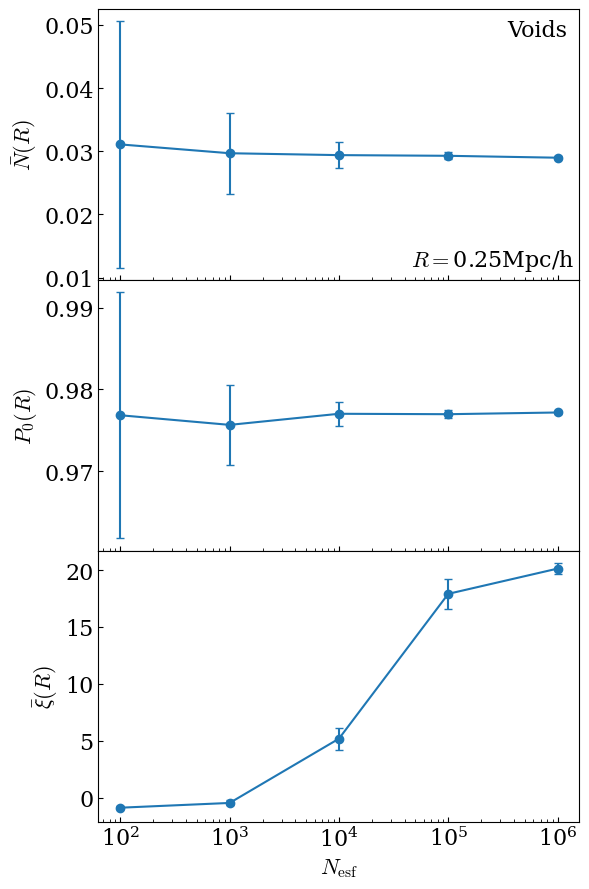

In [6]:
#
#plots con JK
#
import matplotlib.pyplot as plt

from cicTools import delta_P0

#r = 800
#lbox = 205000
#nran = 13333606

namefile = f'../data/stability_voids_jk_{r}kpc.npz'
stats = np.load(namefile)

chi = stats['arr_0']
NXi = stats['arr_1']
P0 = stats['arr_2']
N_mean = stats['arr_3']
xi_mean = stats['arr_4']
chi_std = stats['arr_5']
NXi_std = stats['arr_6']
P0_std = stats['arr_7']
N_mean_std = stats['arr_8']
xi_mean_std = stats['arr_9']
#ns = np.geomspace(10,1000000,30).astype(int)
#ns = np.geomspace(100,10000,4).astype(int)

P0err = delta_P0(P0,ns)

fs = 16
ms = 8
plt.rcParams["xtick.labelsize"] = fs
plt.rcParams["ytick.labelsize"] = fs
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["ytick.direction"] = 'in'
plt.rcParams["xtick.direction"] = 'in'

fig= plt.figure(figsize=(6,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.get_shared_x_axes().join(ax1, ax2, ax3)

"""
Nmean
"""
#N_mean_analytical = nran*(4*np.pi*r**3/3)/(lbox)**3
#ax1.axhline(N_mean_analytical,color='k',alpha=.6)
#ax1.axvline(1e5,ls=':')


ax1.errorbar(ns,N_mean,yerr=N_mean_std,marker='o',capsize=3)

# xtextoffset=-.09
# ax1.text(.6,.25,r'$L_\mathrm{box}=$'+f'{lbox/1000.}Mpc/h', \
#          transform=ax1.transAxes)
# ax1.text(.7,.15,r'$R=$'+f'{r/1000.}'+'Mpc/h', \
#          transform=ax1.transAxes)
# ax1.text(.47,.05,r'$N_\mathrm{ran}/V=$'+f'{nran/lbox**3:.2e}'+\
#          'h\u00b3/Mpc\u00b3', \
#          transform=ax1.transAxes)

ax1.set_ylabel(r'$\bar{N}(R)$',fontsize=fs)
ax1.set_xscale('log')

"""
P0
"""
P0_ran = np.exp(-(nran/lbox**3)*(4./3.)*np.pi*r**3) #theoretical value of P0 for poisson dist.
ax2.errorbar(ns,P0,yerr=P0err,marker='o',capsize=3)
#ax2.axhline(P0_ran,color='k',alpha=.6)
#ax2.axvline(1e5,ls=':')

ax2.set_ylabel(r'$P_0(R)$',fontsize=fs)
ax2.set_xscale('log')

"""
Xi_mean
"""
ax3.errorbar(ns,xi_mean,yerr=xi_mean_std,marker='o',capsize=3)

#ax3.axhline(0,color='k',alpha=.6)
#ax3.axvline(1e5,ls=':')

ax3.set_xlabel(r'$N_\mathrm{esf}$',fontsize=fs)
ax3.set_ylabel(r'$\bar{\xi}(R)$',fontsize=fs)
ax3.set_xscale('log')

ax1.set_xticklabels([])
ax2.set_xticklabels([])

#ax1.set_title('Random sample')
ax1.text(.85,.9,'Voids',fontsize=fs,transform=ax1.transAxes)
ax1.text(.65,.05,r'$R=$'+f'{r/1000.}Mpc/h',fontsize=fs,transform=ax1.transAxes)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.savefig(f'../plots/stability_voids_jk_{r}kpc.png')
#plt.savefig('../plots/stability_randoms_jk.pdf')
plt.show()
